# Illustrate the iEGM through a unitary model

## Monte Carlo Settings

In [1]:
MC_num = 200 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM
specs = { # common specifications across methods
    # 'rho':1.5,      # constant relative risk aversion coefficient

    'num_m':100,    # number of points in the single state: normalized resources
    'max_m':5.0,    # maximum level of normalized resources

    'max_C':10.0,   # maximum level of consumption in iEGM precomputation

    'T': 20,        # number of periods
    'simN':10_000,  # number of agents in simulation

} 

## Load relevant packages

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from UnitaryModel import UnitaryModelClass

plt.rcParams.update({'font.size': 14})

## Illustrate the pre-computation of consumption interpolator

In [3]:
# load local model file and initialize model class
SAVE = True
specs_illustrate = {
    'rho_w':1.5,
    
    'restricted_model':False,

    'num_C':10,
    'max_C':5.0,
    'unequal_C':1.5,
    
    'precompute_intra':True,
}

model = UnitaryModelClass(par=specs_illustrate)
par = model.par

# pre-compute consumption
model.precompute_C()

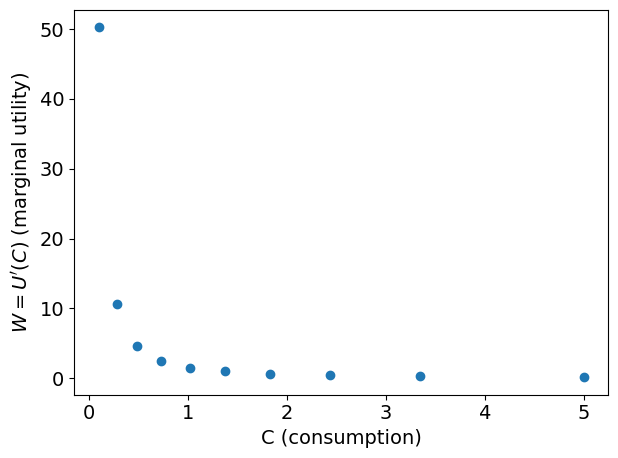

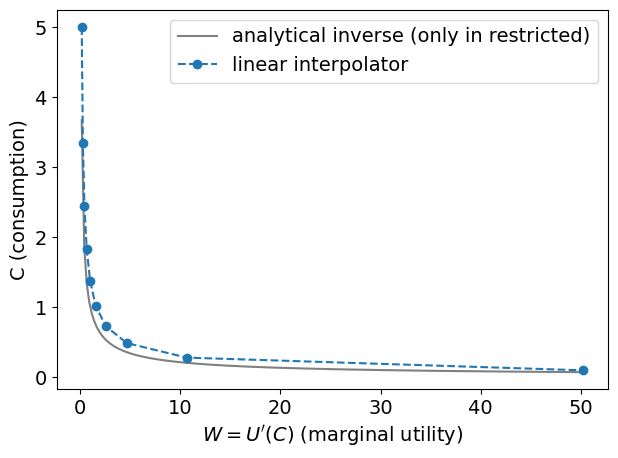

In [4]:
# illustrate the iEGM pre-computation
fig, ax = plt.subplots()
ax.scatter(par.grid_C,par.grid_marg_U)
ax.set(xlabel='C (consumption)',ylabel="$W=U\'(C)$ (marginal utility)");
fig.tight_layout()

fig, ax = plt.subplots()
fine_grid = np.linspace(par.grid_marg_U_flip[0],par.grid_marg_U_flip[-1],200)
ax.plot(fine_grid,model.inv_marg_HH_util(fine_grid),color='gray',label='analytical inverse (only in restricted)')
ax.plot(par.grid_marg_U_flip,par.grid_C_flip,marker='o',linestyle='--',color='tab:blue',label='linear interpolator');
ax.set(xlabel='$W=U\'(C)$ (marginal utility)',ylabel="C (consumption)");
ax.legend();
fig.tight_layout()

## Solve the "true" model using many grid points in VFI

In [5]:
specs_true = {
    'method':'vfi',
    'num_m':500,
}
model_true = UnitaryModelClass(par=specs_true)
%time model_true.solve()
%time model_true.simulate()

model_true_restricted = UnitaryModelClass(par={**specs_true,'restricted_model':True})
%time model_true_restricted.solve()
%time model_true_restricted.simulate()

CPU times: total: 2min 47s
Wall time: 2min 47s
CPU times: total: 31.2 ms
Wall time: 28.4 ms
CPU times: total: 13.2 s
Wall time: 13.1 s
CPU times: total: 31.2 ms
Wall time: 32.2 ms


## Accuracy measures

In [6]:
grid_m_MSE = np.linspace(0.5,5.0,100) # points to evaluatre the consumption function

# interpolator of household utility. This is to simulate lifetime utility without having to resolve the model many times
C_grid = np.linspace(model_true.par.grid_C[0],model_true.par.grid_C[-1],300)
HH_util_grid = np.nan + np.ones(len(C_grid))
for i,C in enumerate(C_grid):
    HH_util_grid[i] = model_true.HH_util(C,recalculate=True)
HH_util = {'C_grid':C_grid,'HH_util_grid':HH_util_grid}

HH_util_grid_restr = np.nan + np.ones(len(C_grid))
for i,C in enumerate(C_grid):
    HH_util_grid_restr[i] = model_true_restricted.HH_util(C,recalculate=True)
HH_util_restr = {'C_grid':C_grid,'HH_util_grid':HH_util_grid_restr}

# calcualte lifetime utility in true model
model_true.lifetime_utility(HH_util) 
model_true_restricted.lifetime_utility(HH_util_restr)

In [7]:
common_specs = {
    'num_m': 20,
    'num_C':30,
}



In [8]:
model_specs_restricted = {
    'vfi, restricted': {'method':'vfi','restricted_model':True},
    'egm, restricted': {'method':'egm','restricted_model':True},
    'iegm, restricted': {'method':'iegm','restricted_model':True},
    'iegm (num), restricted': {'method':'iegm','interp_method':'numerical','restricted_model':True},
}
model_specs = {    
    'vfi': {'method':'vfi','restricted_model':False},
    'iegm': {'method':'iegm','restricted_model':False,'precompute_intra':True},
    'iegm (num)': {'method':'iegm','interp_method':'numerical','restricted_model':False,'precompute_intra':True},
    
}

In [ ]:
models = {}
for name,specs in {**model_specs_restricted,**model_specs}.items():
    print(name)
    models[name] = UnitaryModelClass(par={**common_specs,**specs})
    %time models[name].solve()
    
    # accuracy
    true = model_true_restricted if 'restricted' in name else model_true
    models[name].MSE_consumption(true,grid_m_MSE)
    print(f'MSE in consumption function: {models[name].sim.MSE:.4f}')
    
    models[name].simulate()
    util = HH_util_restr if 'restricted' in name else HH_util
    diff_pct = models[name].lifetime_utility(util,true)
    print(f'Difference in lifetime utility (compared to true model): {diff_pct:.4f}')
    
    comp = models[name].wealth_compensation(util,true)
    print(f'Wealth compensation (pct of household exp. income): {comp:.4f}')
    print('\n',end='')

vfi, restricted
CPU times: total: 656 ms
Wall time: 590 ms
MSE in consumption function: 0.0002
Difference in lifetime utility (compared to true model): 0.0173
Wealth compensation (compared to true model): 0.7638

egm, restricted
CPU times: total: 31.2 ms
Wall time: 31.6 ms
MSE in consumption function: 0.0000
Difference in lifetime utility (compared to true model): 0.0007
Wealth compensation (compared to true model): 0.0000

iegm, restricted
CPU times: total: 31.2 ms
Wall time: 32 ms
MSE in consumption function: 0.0182
Difference in lifetime utility (compared to true model): 1.0315
Wealth compensation (compared to true model): 46.4749

iegm (num), restricted
CPU times: total: 78.1 ms
Wall time: 84.9 ms
MSE in consumption function: 0.0000
Difference in lifetime utility (compared to true model): 0.0007
Wealth compensation (compared to true model): 0.0000

vfi
CPU times: total: 8.64 s
Wall time: 8.59 s
MSE in consumption function: 0.0001
Difference in lifetime utility (compared to true mod

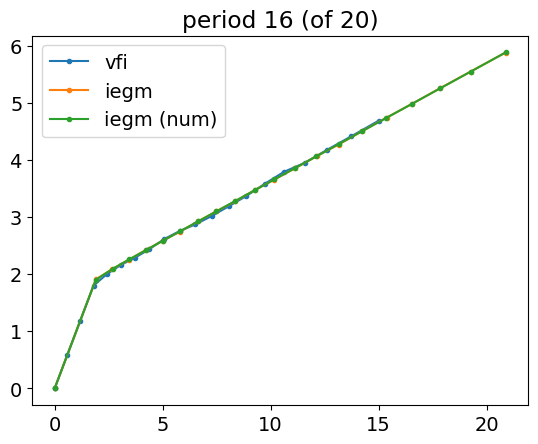

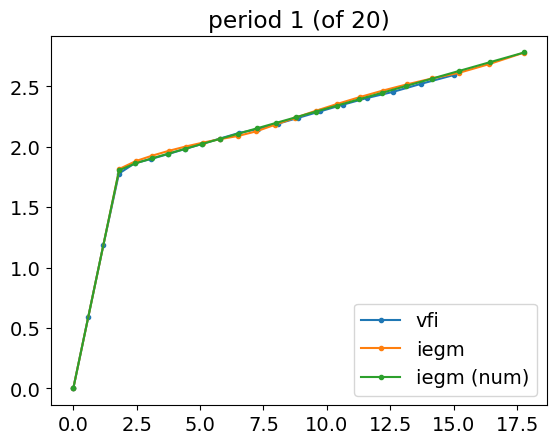

In [10]:
for t in (-5,-20):
    fig,ax = plt.subplots()
    for name,specs in model_specs.items():
        m_interp = np.concatenate((np.array([0.0]),models[name].sol.M[t]))
        c_interp = np.concatenate((np.array([0.0]),models[name].sol.C[t]))
        ax.plot(m_interp,c_interp,label=name,marker='.')
        ax.legend();
        ax.set(title=f'period {models[name].par.T+t+1} (of {models[name].par.T})');

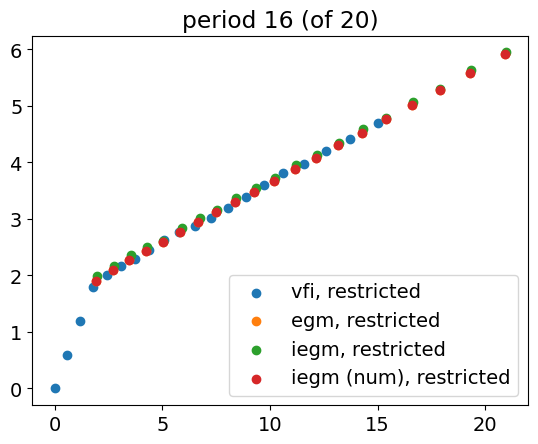

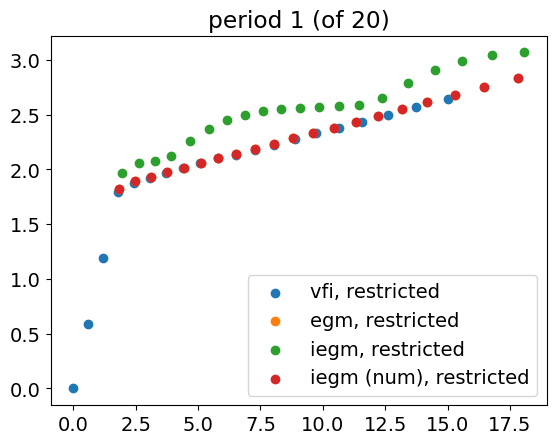

In [11]:
for t in (-5,-20):
    fig,ax = plt.subplots()
    for name,specs in model_specs_restricted.items():
        ax.scatter(models[name].sol.M[t,:],models[name].sol.C[t,:],label=name)
        ax.legend();
        ax.set(title=f'period {models[name].par.T+t+1} (of {models[name].par.T})');

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
test_specs = {
    
    'num_m': 100,
    'num_C':50,
    
}


In [ ]:
# solve models with different approaches
models = dict()
for restricted in (True,False):
    restricted_str = 'unrestricted model' if not restricted else "restricted model"
    print(f'***** {restricted_str} *****')
    for method in ('vfi','egm','iegm'):
        for interp_method in ('linear',):
        # for interp_method in ('linear','numerical'):
            interp_str = ' num' if (interp_method=='numerical') & (method == 'iegm') else ''
            if (interp_method=='numerical') & (method != 'iegm'):
                continue
            for precomputed in (False,True):
                precomputed_str = '' if not precomputed  else ' (precomputed intra)'
                if (method=='egm') & (not restricted):
                    continue
                # if (method != 'iegm') & (precomputed):
                #     continue
                print(method+interp_str+precomputed_str)
                model_name = method+restricted_str+precomputed_str+interp_str
                models[model_name] = UnitaryModelClass(par={**test_specs,'method':method,'restricted_model':restricted,'precompute_intra':precomputed,'interp_method':interp_method})
                %time models[model_name].solve()
                print('\n',end='')

In [ ]:
# Q: why is the precompute_intra so important? Also for iEGM? is it the last-period and the calculation after finding Ctot in general?
# A: The use of the marginal utility in the Euler equation requires many re-calucations of the intra-temporal problem. Precomputing it is obious.
# But then what about the numerical EGM? Should that not pre-compute the marginal util?

# there is something happening with the interpolation over different grids. If I try to use the precomputed marginal_HH_util  and interpolate, then there is a problem elsewhere. Is it extrapolation that leads to negative marginal utility...?

In [ ]:
for restricted in (True,False):
    restricted_str = '' if not restricted else ", restricted"
    for t in (-5,-20):
        fig,ax = plt.subplots()
        for method in ('vfi','egm','iegm'):
            for interp_method in ('linear',):
            # for interp_method in ('linear','numerical'):
                interp_str = 'num' if (interp_method=='numerical') & (method == 'iegm') else ''
                if (interp_method=='numerical') & (method != 'iegm'):
                    continue
                for precomputed in (False,True):
                    precomputed_str = '' if not precomputed  else ' (precomputed)'
                    if (method=='egm') & (not restricted):
                        continue
                    if (method != 'iegm') & (precomputed):
                        continue
                    
                    model_name = method+restricted_str+precomputed_str+interp_str
                    ax.scatter(models[model_name].sol.M[t,:],models[model_name].sol.C[t,:],label=model_name+precomputed_str)
                    ax.legend();
                    ax.set(title=f'period {models[model_name].par.T+t+1} (of {models[model_name].par.T})'+restricted_str);

In [ ]:
stop
# all the monte carlo stuff is not implemented yet.

In [ ]:
# model_true = UnitaryModelClass({par=**true_specs'num_m:300})
# model_true.solve()

Monte Carlo Runs

In [ ]:
PRINT = False
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
    
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
util = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),
    
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    # simulate true model (solved once above)
    model_true.par.seed = i_mc
    model_true.allocate_draws()
    model_true.simulate()
    true_mean_lifetime_util = model_true.sim.mean_lifetime_util

    # setup alternative model solutios
    model = BufferStockModelClass(par=specs)
    model.par.seed = i_mc
    model.allocate()

    # VFI and EGM
    for method in ['vfi','egm']:
        model.par.method = method
        
        # Timing
        t0 = time()
        model.solve()
        timing[model.par.method][i_mc] = time() - t0

        # Accuracy
        model.simulate()
        error[model.par.method][i_mc] = model.sim.mean_log10_euler
        util[model.par.method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    # iEGM
    model.par.method = 'iegm'
    for interp_method in ('linear',):
        for interp_inverse in (False,True):
            model.par.interp_method = interp_method
            model.par.interp_inverse = interp_inverse
            method = f'{model.par.method}, {interp_method} inverse' if interp_inverse else f'{model.par.method}, {interp_method}'
            for i_c,num_C in enumerate(C_num_grid):
                model.par.num_C = num_C
                model.allocate()

                # Timing
                t0 = time()
                model.solve()
                timing[method][num_C][i_mc] = time() - t0

                # Accuracy
                model.simulate()
                error[method][num_C][i_mc] = model.sim.mean_log10_euler
                util[method][num_C][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    model.par.interp_method = 'numerical'
    model.par.interp_inverse = False
    method = f'egm, {model.par.interp_method}'
    # Timing
    t0 = time()
    model.solve()
    timing[method][i_mc] = time() - t0

    # Accuracy
    model.simulate()
    error[method][i_mc] = model.sim.mean_log10_euler
    util[method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100


In [ ]:
print('lifetime util & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi','egm','egm, numerical'):
    util_now = np.mean(util[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {util_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        util_now = np.mean(util[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {util_now:2.3f} & {time_now:2.3f} ')